In [4]:
from cmp import *
% matplotlib notebook

<IPython.core.display.Javascript object>


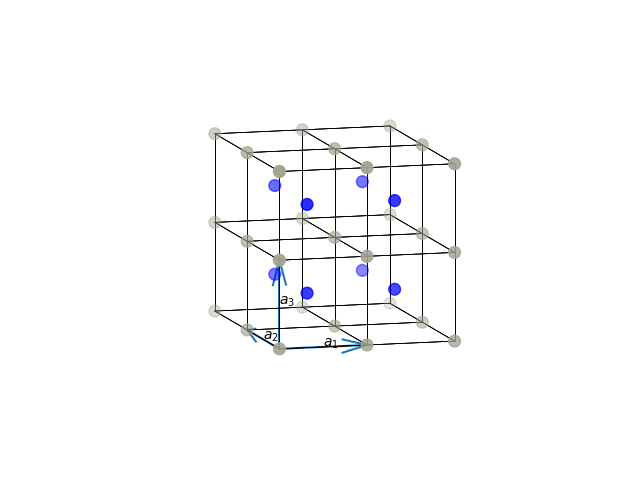

In [5]:
# Inputs

# Lattice vectors (3 vectors of length 3)
a = 1
b = 2
a1 = np.array([1, 0, 0])
a2 = np.array([0, 1, 0])
a3 = np.array([0, 0, 1])
theta = 80*np.pi/180

# Array of basis vectors
basis = np.array([[0,0,0],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5]])
# Colors for each of the basis vectors
colors = ('xkcd:cement','b','b','b')
# Size multiplier for each of the atoms. Default is 1
sizes = (2,1,1,1)


# Gridline type:
# Hard: lines along cartesian axes at integer spacings
# Soft: Lines along cartesian axes. Takes into account nonequal lattice spacing
# LatticeVectors: Lines along the latticevectors (only on lattice points)
GridType = "lattice"

# Limit type:
# Hard: Sets a hard limit on the plotting boundary (default  x = y = z = [0,2])
# Dynamic: Sets the limits as max(nx*a1,ny*a2,nz*a3), so we include nx unitcells in the a1 direction, etc.
# WDynamic: Sets the limits r_min = n_min*[a1 a2 a3] and likewise for n_max
LimType = "dynamic"
Maxs = [2,2,2]
Mins = [0,0,0]

#LatticeCreator(a1,a2,a3,basis,colors,sizes,LimType,GridType,Mins,Maxs)
LatticeCreator(Lattice="conventional bcc", colors=["xkcd:cement","b","b","b"],LimType=LimType,Maxs=Maxs)

In [64]:
def rotateHex(a1,a2,a3,basis):
    """
    Rotator for the hexagonal structure
    """
    mag_a1 = mag(a1)
    mag_a2 = mag(a2)
    mag_a3 = mag(a3)
    cos12 = a1.dot(a2) / (mag_a1 * mag_a2)
    cos31 = a1.dot(a3) / (mag_a1 * mag_a3)
    cos23 = a2.dot(a3) / (mag_a2 * mag_a3)
    eq = np.isclose
    x = np.array([1,0,0])
    z = np.array([0,0,1])
    
    # Rotate the lattice according to which vectors form the triangular lattice
    if eq(0.5, cos12):
        # a1 and a2 form triangular lattice. Align a1 along x
        a1cross = np.cross(a1,x)
        theta = np.arcsin(mag(a1cross)/mag(a1))
        r1 = RotMatrix(a1cross, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)
        
        # now rotate a3 so it's parallel to z, with x as rotation axis
        theta = np.arccos(a3.dot(z) / (mag_a3))
        r3 = RotMatrix(x, theta)
        A1, A2, A3, Basis = rotate(a1, a2, a3, basis, r3)
        # Alright, so I don't know how to get the proper rotation direction, so we just check if it's rotated properly
        if eq(A2[2],0):
            # We rotated correctly
            a1, a2, a3, basis = A1, A2, A3, Basis
        else:
            # We didn't rotate correctly, so we rotate the other way twice
            r3 = RotMatrix(x, -theta)
            a1, a2, a3, basis = rotate(a1, a2, a3, basis, r3)
        
    elif eq(0.5, cos23):
        # a2 and a3 form triangular lattice. Align a2 along x
        a2cross = np.cross(a2,x)
        theta = np.arcsin(mag(a2cross)/mag(a2))
        r2 = RotMatrix(a2cross, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)
        
        # now rotate a1 so it's parallel to z, with x as rotation axis
        theta = np.arccos(a1.dot(z) / (mag_a1))
        r1 = RotMatrix(x, theta)
        A1, A2, A3, Basis = rotate(a1, a2, a3, basis, r1)
        # Alright, so I don't know how to get the proper rotation direction, so we just check if it's rotated properly
        # It's rotated properly if the z-coordinate of A3 is 0
        if eq(A3[2],0):
            # We rotated correctly
            a1, a2, a3, basis = A1, A2, A3, Basis
        else:
            # We didn't rotate correctly, so we rotate the other way twice
            r1 = RotMatrix(x, -theta)
            a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)
        
        
    elif eq(0.5, cos31):
        # a1 and a3 form triangular lattice. Align a1 along x
        a1cross = np.cross(a1,x)
        theta = np.arcsin(mag(a1cross)/mag(a1))
        r1 = RotMatrix(a1cross, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)
        
        # now rotate a2 so it's parallel to z, with x as rotation axis
        theta = np.arccos(a2.dot(z) / (mag_a2))
        r2 = RotMatrix(x, theta)
        A1, A2, A3, Basis = rotate(a1, a2, a3, basis, r2)
        # Alright, so I don't know how to get the proper rotation direction, so we just check if it's rotated properly
        if eq(A3[2],0):
            # We rotated correctly
            a1, a2, a3, basis = A1, A2, A3, Basis
        else:
            # We didn't rotate correctly, so we rotate the other way twice
            r3 = RotMatrix(x, -theta)
            a1, a2, a3, basis = rotate(a1, a2, a3, basis, r3)
    else:
        print('something went wrong')
    
    return a1, a2, a3, basis

In [63]:
def rotate(a1,a2,a3,basis,R):
    """
    Rotates the lattice
    """
    return R@a1, R@a2, R@a3, (R@basis.T).T
    
def rotator(a1,a2,a3,basis,latticetype=None,verb=False):
    """
    Rotates the lattice to make plotting gridlines easier
    """
    # We remember, that |a x b| = |a| |b| sin(theta)
    eq = np.isclose
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    # Check for orthogonality
    ortho12 = eq(0, np.dot(a1, a2))
    ortho31 = eq(0, np.dot(a1, a3))
    ortho23 = eq(0, np.dot(a2, a3))
    
    if verb:
        print("Before:")
        print(a1)
        print(a2)
        print(a3)
        print(basis)
    
    if "hexagonal" in latticetype:
        a1, a2, a3, basis = rotateHex(a1, a2, a3, basis)
    elif latticetype == "fcc":
        a1, a2, a3, basis = rotatefcc(a1, a2, a3, basis)
    elif ortho12:
        # We choose a1 to align along x
        a1cross = np.cross(a1,x)
        theta = np.arcsin(mag(a1cross)/mag(a1))
        r1 = RotMatrix(a1cross, theta)
        a1, a2, a3, basis = rotate(a1,a2,a3,basis,r1)
        
        # Now we align a2 along y
        # But we gotta make sure we rotate in the right direction
        a2cross = np.cross(a2,y)
        sign = np.sign(a2cross)[0]
        theta = sign * np.arcsin(mag(a2cross)/mag(a2))
        r2 = RotMatrix(x, theta)
        a1, a2, a3, basis = rotate(a1,a2,a3,basis,r2)
    elif ortho23:
        # We choose a2 to align along x
        a2cross = np.cross(a2,x)
        theta = np.arcsin(mag(a2cross)/mag(a2))
        r2 = RotMatrix(a2cross, theta)
        a1, a2, a3, basis = rotate(a1,a2,a3,basis,r2)
        
        # Now we align a3 along y
        a3cross = np.cross(a3,y)
        sign = np.sign(a3cross)[0]
        theta = sign * np.arcsin(mag(a3cross)/mag(a3))
        r3 = RotMatrix(x, theta)
        a1, a2, a3, basis = rotate(a1,a2,a3,basis,r3)
    elif ortho31:
        # We choose a1 to align along x
        a1cross = np.cross(a1,x)
        theta = np.arcsin(mag(a1cross)/mag(a1))
        r1 = RotMatrix(a1cross, theta)
        a1, a2, a3, basis = rotate(a1,a2,a3,basis,r1)
        
        # Now we align a2 along y
        a3cross = np.cross(a3,y)
        sign = np.sign(a3cross)[0]
        theta = sign * np.arcsin(mag(a3cross)/mag(a3))
        r3 = RotMatrix(x, theta)
        a1, a2, a3, basis = rotate(a1,a2,a3,basis,r3)
    else:
        # Well, it doesn't really matter here, if none of them are orthogonal to each other. We'll just use latticevector gridlines and leave this be.
        pass
    
    # Let's sanitize the coordinates that are close to 0 (say if a1x = 2*10^-10, then we set it equal 0)
    a1[eq(a1,0)] = 0
    a2[eq(a2,0)] = 0
    a3[eq(a3,0)] = 0
    basis[eq(basis,0)] = 0
    
    if verb:
        print("after")
        print(a1)
        print(a2)
        print(a3)
        print(basis)
    
    return a1,a2,a3,basis

In [108]:
def rotatefcc(a1,a2,a3,basis):
    """
    Rotate the (primitive) fcc lattice for easier gridline plotting
    """
    eq = np.isclose
    a1prop = np.array([1/2, 1/2, 0])
    a2prop = np.array([1/2, 0, 1/2])
    a3prop = np.array([0, 1/2, 1/2])

    # First we orient a1 along (0.5,0.5,0)
    a1cross = np.cross(a1,a1prop)
    theta = np.arcsin(mag(a1cross) / (mag(a1) * mag(a1prop)))
    r1 = RotMatrix(a1cross, theta)
    a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)
    
    # Next we try orienting a2 along a2prop. Then we see if a3 is aligned properly
    # We need to rotate along a1, such that this is kept fixed
    
    # To find the angle we need to rotate it with, we use the vector rejection of a2 and a2prop, as these are perpendicular to a1
    theta, r2 = RotMatrixAlong(a1prop, a2, a2prop)
    A1, A2, A3, Basis = rotate(a1, a2, a3, basis, r2)
    if eq(A2, a2prop).all():
        # We rotated properly
        a1, a2, a3, basis = A1, A2, A3, Basis
    else:
        # Rotate the other way!
        r2 = RotMatrix(a1prop, -theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)
    
    # Now we check if a3 is right. If not we rotate a2 along a3prop instead
    if eq(a3,a3prop).all():
        pass
    else:
        theta, r2 = RotMatrixAlong(a1prop, a2, a3prop)
        A1, A2, A3, Basis = rotate(a1, a2, a3, basis, r2)
        if eq(A2, a3prop).all():
            # We rotated properly
            a1, a2, a3, basis = A1, A2, A3, Basis
        else:
            # Rotate the other way!
            r2 = RotMatrix(a1prop, -theta)
            a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)

    return a1, a2, a3, basis
    
def RotMatrixAlong(a,b,c):
    """
    creates the rotation matrix which rotates b about a, such that it coincides with c
    """
    
    # First we need the relevant vector rejections
    brej = b - b.dot(a) / (mag(a)**2) * a
    crej = c - c.dot(a) / (mag(a)**2) * a
    
    # Next we get the angle between the rejections
    theta = np.arccos(brej.dot(crej) / (mag(brej) * mag(crej)))
    
    # and the relevant rotation matrix
    R = RotMatrix(a,theta)
    return theta,R

In [109]:
R = RotMatrix()
(a1,a2,a3), basis = LatticeChooser("fcc")
a1,a2,a3,basis = rotate(a1,a2,a3,basis,R)

print(a1)
print(a2)
print(a3)

a1,a2,a3,basis = rotatefcc(a1,a2,a3,basis)

print(a1)
print(a2)
print(a3)

[0.24706032 0.65530861 0.09763107]
[0.65530861 0.09763107 0.24706032]
[0.09763107 0.24706032 0.65530861]
[ 5.00000000e-01  5.00000000e-01 -6.12089033e-17]
[5.00000000e-01 1.11022302e-16 5.00000000e-01]
[-5.55111512e-17  5.00000000e-01  5.00000000e-01]


In [65]:
R = RotMatrix()
lattices = ["simple cubic", "fcc", "bcc", "conventional fcc",
                "conventional bcc", "base centred cubic", "tetragonal",
                "tetragonal body centred", "tetragonal face centred",
                "tetragonal base centred", "orthorhombic",
                "orthorhombic base centred", "orthorhombic body centred",
                "orthorhombic face centred", "simple monoclinic",
                "base centred monoclinic 1", "base centred monoclinic 2",
                "base centred monoclinic 3", "hexagonal 1", "hexagonal 2",
                "triclinic", "rhombohedral"]
for name in lattices:
    # Create the lattice
    lattice, basis = LatticeChooser(name)
    # rotate the lattice and basis
    lattice = (R@lattice.T).T
    basis = (R@basis.T).T
    a1,a2,a3 = lattice
    print(name)
    a1,a2,a3,basis = rotator(a1,a2,a3,basis,latticetype =name, verb=True)

simple cubic
Before:
[ 0.80473785  0.50587936 -0.31061722]
[-0.31061722  0.80473785  0.50587936]
[ 0.50587936 -0.31061722  0.80473785]
[0. 0. 0.]
after
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 0.]
fcc
Before:
[0.24706032 0.65530861 0.09763107]
[0.65530861 0.09763107 0.24706032]
[0.09763107 0.24706032 0.65530861]
[0. 0. 0.]
after
[0.24706032 0.65530861 0.09763107]
[0.65530861 0.09763107 0.24706032]
[0.09763107 0.24706032 0.65530861]
[0. 0. 0.]
bcc
Before:
[ 0.80473785  0.50587936 -0.31061722]
[-0.31061722  0.80473785  0.50587936]
[0.5 0.5 0.5]
[0. 0. 0.]
after
[1. 0. 0.]
[0. 1. 0.]
[0.5 0.5 0.5]
[0. 0. 0.]
conventional fcc
Before:
[ 0.80473785  0.50587936 -0.31061722]
[-0.31061722  0.80473785  0.50587936]
[ 0.50587936 -0.31061722  0.80473785]
[[0.         0.         0.        ]
 [0.24706032 0.65530861 0.09763107]
 [0.65530861 0.09763107 0.24706032]
 [0.09763107 0.24706032 0.65530861]]
after
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[[0.  0.  0. ]
 [0.5 0.5 0. ]
 [0.5 0.  0.5]
 [0.  0.5 0.5]]
conv